# <b>Introduction to Statistical Learning, 2nd Edition</b>
## by James, Witten, Hastie, Tibshirani

### Notes by Melis Tekant

## Chapter 5  - Resampling Methods

In [224]:
import pandas as pd
import numpy as np
import matplotlib as mpl
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split, LeaveOneOut, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In this chapter, two resampling methods will be discussed: cross-validation and bootstrap. These are methods to estimate the test error rate by removing a portion of the training observations from the regression method, then applying it to those points. This can be done for both quantitative and qualitative response.

We can use a validation set approach: randomly dividing the dataset into training and validation. Fit the model on the training set, and predict on the validation set. 

In [137]:
# Using the auto dataset, dropping the bad entries as in Ch 3.

auto = pd.read_csv('/Users/melistekant/Documents/Python Projects/ISLR2/Auto.csv')
badentry = auto.horsepower.isin(['?'])
badloc = list(badentry[badentry==True].index)
autocl = auto.drop(index=badloc)
autocl.horsepower = pd.to_numeric(autocl.horsepower,errors = 'coerce',downcast = 'integer')
autocl = autocl.reset_index()
autocl = autocl.drop(columns='index',axis =1)

In [143]:
X = autocl[['horsepower']]
y = autocl[['mpg']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5,random_state=0)

polydeg = np.linspace(1,10,10)

mse_poly_1 = []

for deg in polydeg:
    polyreg = PolynomialFeatures(degree = int(deg))
    X_poly = polyreg.fit_transform(X_train)
    X_test_poly = polyreg.fit_transform(X_test)
    linreg = LinearRegression()
    results = linreg.fit(X_poly,y_train)
    y_pred = linreg.predict(X_test_poly)
    mse = np.sum((y_test-y_pred)**2)/len(y_pred)
    mse_poly_1.append(mse)
    
# Repeating different test/validation splits 10 times by not putting a random state number

mse_poly_n = np.zeros((10,len(polydeg)))

for i in range(0,10):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

    for deg in polydeg:
        polyreg = PolynomialFeatures(degree = int(deg))
        X_poly = polyreg.fit_transform(X_train)
        X_test_poly = polyreg.fit_transform(X_test)
        linreg = LinearRegression()
        results = linreg.fit(X_poly,y_train)
        y_pred = linreg.predict(X_test_poly)
        mse = np.sum((y_test-y_pred)**2)/len(y_pred)
        mse_poly_n[i][int(deg-1)] = mse




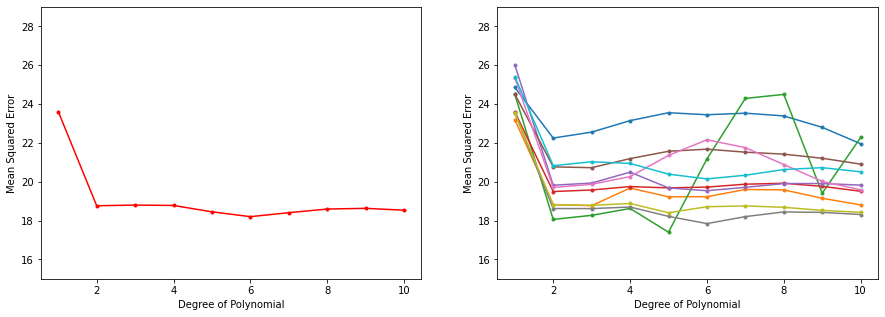

In [144]:
plt.subplots(figsize=(15,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(polydeg,mse_poly_1,color='r',marker='.')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.ylim([15,29])

ax2 = plt.subplot(1,2,2)
for i in range(0,10):
    ax2.plot(polydeg,mse_poly_n[i],marker='.')   
ax2.set_xlabel('Degree of Polynomial')
ax2.set_ylabel('Mean Squared Error')
ax2.set_ylim([15,29]);

Instead of splitting the dataset evenly into training and validation sets, we can remove a single point and use the rest of the dataset for training. We can then calculate the MSE for this point, and repeat the same procedure for all the points in the set. This is called leave-one-out-cross-validation method (LOOCV) and tends to not overestimate the MSE as much as the method above.

In [233]:
mse_poly_1 = []

for deg in polydeg:
    mse = 0
    for i in range(0,len(y)):
        X_train, X_test = X.drop(index = i), X.loc[[i]]
        y_train, y_test = y.drop(index = i), y.loc[[i]]
        polyreg = PolynomialFeatures(degree = int(deg))
        X_poly = polyreg.fit_transform(X_train)
        X_test_poly = polyreg.fit_transform(X_test)
        linreg = LinearRegression()
        results = linreg.fit(X_poly,y_train)
        y_pred = linreg.predict(X_test_poly)
        mse = mse + float(((y_test.mpg-float(y_pred))**2/len(y)).values) 
    mse_poly_1.append(mse)

In [299]:
# Repeating above calculation with 10-fold CV

n = 10
mse_poly_n = np.zeros((9,len(polydeg)))
kfold = KFold(n_splits = n,random_state=None,shuffle=True)

for i in range(0,9):
    mse = np.zeros((int(polydeg[-1]),1))
    for train_idx, test_idx in kfold.split(X):
        X_train , X_test = X.loc[train_idx], X.loc[test_idx]
        y_train, y_test = y.loc[train_idx], y.loc[test_idx]
        for deg in polydeg :
            polyreg = PolynomialFeatures(degree = int(deg))
            X_poly = polyreg.fit_transform(X_train)
            X_test_poly = polyreg.fit_transform(X_test)
            linreg = LinearRegression()
            results = linreg.fit(X_poly,y_train)
            y_pred = linreg.predict(X_test_poly)
            mse[int(deg-1)] = mse[int(deg-1)] + np.sum((y_test-y_pred)**2)/len(y_pred)/n
    mse_poly_n[i][:] = mse.T


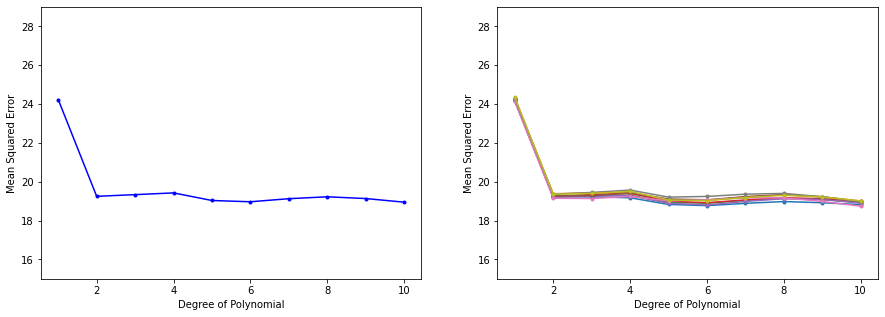

In [300]:
plt.subplots(figsize=(15,5))

ax1 = plt.subplot(1,2,1)
ax1.plot(polydeg,mse_poly_1,color='b',marker='.')
plt.xlabel('Degree of Polynomial')
plt.ylabel('Mean Squared Error')
plt.ylim([15,29])

ax2 = plt.subplot(1,2,2)
for i in range(0,9):
    ax2.plot(polydeg,mse_poly_n[i],marker='.')   
ax2.set_xlabel('Degree of Polynomial')
ax2.set_ylabel('Mean Squared Error')
ax2.set_ylim([15,29]);

In the n-fold CV method, the sample is separated into n groups. 1 group is held out as a test group while the remaining n-1 groups are used for training. CV is calculated, this is repeated n-1 more times until each group has been used as a test group. The overall CV is calculated by taking the mean of the n calculated CVs. This way, the fit can be performed only n times instead of the number of samples as is required for the LOOCV method -- this might become computationally very intensitve for large datasets. 